# Introduction
In this file, we will explore a week's worth of unplanned alerts data, and figure out which one we could suitably use for analysis. 

In [103]:
import pandas as pd
import numpy as np
import json
from os import listdir
import datetime

# Load data
We have collected alerts data in snapshots, which are queried from the MTA Service Alerts API every 10 minutes. We would like to gather these all together, and look at the individual alerts. 

In [16]:
all_alerts = []

file_names = [f for f in listdir("unplanned_data/") if "json" in f]

for file_name in file_names:
    with open ("unplanned_data/" + file_name, 'r') as f:
        data = json.load(f)
        all_alerts += data

len(all_alerts)

33476

So we're working with 33476 lines of data. Not all of these alerts will be unique. To continue our analysis, we will first load the alert data into a DataFrame

In [19]:
alert_df = pd.DataFrame(all_alerts)
alert_df.id.nunique()

582

That's already looking a lot better: we have 582 unique alerts. Now let's take a look at the type of alerts we're finding.

In [20]:
alert_df.head()

,startDate,direction,endDate,statusSummary,id,priority,line,creationDate,statusDescription
0,2021-11-08T23:45:00-0500,0,2021-11-09T05:00:00-0500,No Scheduled Service,lmm:planned_work:1467,1,3,2021-10-11T11:27:18-0400,<p>[2] trains make [3] stops between <b>Times ...
1,2021-11-08T23:45:00-0500,1,2021-11-09T05:00:00-0500,No Scheduled Service,lmm:planned_work:1467,1,3,2021-10-11T11:27:18-0400,<p>[2] trains make [3] stops between <b>Times ...
2,2021-11-05T21:30:00-0400,1,2021-11-06T06:30:00-0400,Extra Service,lmm:planned_work:1369,10,3,2021-10-04T11:37:03-0400,<p>[3] trains run to/from <b>New Lots Av</b> a...
3,2021-11-05T21:30:00-0400,0,2021-11-06T06:30:00-0400,Extra Service,lmm:planned_work:1369,10,3,2021-10-04T11:37:03-0400,<p>[3] trains run to/from <b>New Lots Av</b> a...
4,2021-11-13T07:00:00-0500,1,2021-11-13T19:00:00-0500,Extra Service,lmm:planned_work:1471,10,W,2021-10-11T11:44:10-0400,<p><strong>Note: </strong>No [7] trains betwee...


In [23]:
alert_df[['statusSummary', 'id']].head()

,statusSummary,id
0,No Scheduled Service,lmm:planned_work:1467
1,No Scheduled Service,lmm:planned_work:1467
2,Extra Service,lmm:planned_work:1369
3,Extra Service,lmm:planned_work:1369
4,Extra Service,lmm:planned_work:1471


One important observation here is the fact that, even when the `statusSummary` field does not include "Planned", the `id` may still specify that the alert pertains to a planned event. As such, we should filter out the rows where this is indeed the case.

## Filter unplanned alerts

In [27]:
id_df = alert_df.id.str.split(":", expand=True)
id_df.head()

,0,1,2
0,lmm,planned_work,1467
1,lmm,planned_work,1467
2,lmm,planned_work,1369
3,lmm,planned_work,1369
4,lmm,planned_work,1471


In [29]:
id_df[1].unique()

array(['planned_work', 'alert'], dtype=object)

We will filter out all rows which have a value of `planned_work` here.

In [32]:
keep_index = id_df[id_df[1] == 'alert'].index

In [37]:
alert_df = alert_df.loc[keep_index]
alert_df.shape

(6812, 9)

In [39]:
alert_df.id.nunique()

557

After this process, we are left with 557 unique alerts. 

# Analysis

In [41]:
alert_df.reset_index(inplace=True)
alert_df.head()

,index,startDate,direction,endDate,statusSummary,id,priority,line,creationDate,statusDescription
0,16,2021-10-29T17:17:39-0400,0,None,Delays,lmm:alert:104257,22,Q,2021-10-29T07:18:45-0400,<p>You may wait longer for a ‌[Q] train. We're...
1,17,2021-10-29T17:17:39-0400,1,None,Delays,lmm:alert:104257,22,Q,2021-10-29T07:18:45-0400,<p>You may wait longer for a ‌[Q] train. We're...
2,28,2021-10-29T23:29:14-0400,0,None,Delays,lmm:alert:104351,22,4,2021-10-29T21:51:25-0400,<p>Southbound [4] are delayed while our crews ...
3,29,2021-10-29T23:29:14-0400,1,None,Delays,lmm:alert:104351,22,4,2021-10-29T21:51:25-0400,<p>Southbound [4] are delayed while our crews ...
4,48,2021-10-31T03:24:09-0400,0,2021-10-31T03:46:09-0400,Delays,lmm:alert:104593,22,D,2021-10-31T03:24:09-0400,<p>You may experience a longer wait for northb...


In [42]:
alert_df.sort_values(by='priority', ascending=False)

,index,startDate,direction,endDate,statusSummary,id,priority,line,creationDate,statusDescription
1807,8947,2021-10-28T23:15:24-0400,0,None,Multiple Impacts,lmm:alert:104049,37,2,2021-10-28T22:25:24-0400,<p>[2] and [3] trains are delayed and/or rerou...
2195,10749,2021-10-27T15:57:40-0400,0,None,Multiple Impacts,lmm:alert:103691,37,L,2021-10-27T15:47:26-0400,<p>[L] trains are delayed and/or rerouted whil...
824,3977,2021-10-29T12:21:23-0400,0,None,Multiple Impacts,lmm:alert:104191,37,5,2021-10-29T09:40:43-0400,<p>Northbound [4] [5] trains are running at sl...
825,3978,2021-10-29T12:21:23-0400,1,None,Multiple Impacts,lmm:alert:104191,37,5,2021-10-29T09:40:43-0400,<p>Northbound [4] [5] trains are running at sl...
3874,18666,2021-11-01T10:18:49-0400,0,None,Multiple Impacts,lmm:alert:104864,37,A,2021-11-01T09:43:24-0400,<p>Northbound [A] trains are running at slower...
...,...,...,...,...,...,...,...,...,...,...
3522,16844,2021-10-27T15:57:40-0400,1,None,Boarding Change,lmm:alert:103690,15,L,2021-10-27T15:47:26-0400,<p>[L] trains are delayed and/or rerouted whil...
4563,22087,2021-10-27T17:08:34-0400,0,None,Boarding Change,lmm:alert:103709,15,D,2021-10-27T17:08:34-0400,<p>207 St-bound [A] trains are rerouted on the...
4562,22086,2021-10-27T17:08:34-0400,1,None,Boarding Change,lmm:alert:103709,15,D,2021-10-27T17:08:34-0400,<p>207 St-bound [A] trains are rerouted on the...
5096,24902,2021-10-29T18:08:46-0400,0,None,Boarding Change,lmm:alert:104271,15,6,2021-10-29T18:08:46-0400,<p>[6]</p>


In [59]:
alert_df = alert_df.drop("index", axis=1)
alert_df.shape

KeyError: "['index'] not found in axis"

In [ ]:
alert_df = alert_df.drop_duplicates()
alert_df.shape

(1640, 9)

In [92]:
relevant_alert = "lmm:alert:104049"

alert_df[alert_df.id == relevant_alert]

,startDate,direction,endDate,statusSummary,id,priority,line,creationDate,statusDescription
372,2021-10-28T23:15:24-0400,1,None,Multiple Impacts,lmm:alert:104049,37,2,2021-10-28T22:25:24-0400,<p>[2] and [3] trains are delayed and/or rerou...
373,2021-10-28T23:15:24-0400,0,None,Multiple Impacts,lmm:alert:104049,37,2,2021-10-28T22:25:24-0400,<p>[2] and [3] trains are delayed and/or rerou...
374,2021-10-28T23:15:24-0400,1,None,Multiple Impacts,lmm:alert:104049,37,3,2021-10-28T22:25:24-0400,<p>[2] and [3] trains are delayed and/or rerou...
375,2021-10-28T23:15:24-0400,0,None,Multiple Impacts,lmm:alert:104049,37,3,2021-10-28T22:25:24-0400,<p>[2] and [3] trains are delayed and/or rerou...


In [93]:
alert_df[alert_df.id == relevant_alert].iloc[0]['statusDescription']

'<p>[2] and [3] trains are delayed and/or rerouted while emergency teams respond to a person who was struck by a train at <b>116 St</b>. </p><p>Some northbound [2] trains are running along the [5] line from <b>Nevins St</b> to <b>149 St-Grand Concourse</b>. </p><p>Some northbound [2] trains are running on the southbound track between <b>Central Park North (110 St)</b> and <b>135 St</b>. </p><p>Northbound [3] trains will end at <b>137 St-City College</b> via the [1] line and turn back southbound. </p><p>For continued service along Lenox Av, take the<strong> M7 </strong>bus or see buses near you at bustime.mta.info. </p><p>See a station agent for a free courtesy pass to continue your trip.</p>'

This is great -- the alert is informing people to take the M7 bus. This allows us to dive into the effect the alert may have had on ridership levels on this bus. Let's first see for how long the alert was active. 

In [94]:
(alert_df[alert_df.id == relevant_alert].iloc[0].startDate, alert_df[alert_df.id == relevant_alert].iloc[0].endDate)

('2021-10-28T23:15:24-0400', None)

One problem arises here: there is no `endDate` recorded. This is likely a result of the nature of these alerts: they do not have a planned end time. We can inform the time at which the alert stopped being active, however, by looking at the different files. For this purpose, we would need to include a timestamp of the creation date of the file. 

## Inferring end time of alert

In [95]:
time_alerts = []

for file_name in file_names:
    time = file_name[9:19]
    with open ("unplanned_data/" + file_name, 'r') as f:
        data = json.load(f)
        for dic in data:
            dic['time'] = time
        time_alerts += data

In [96]:
time_df = pd.DataFrame(time_alerts)
time_df.shape

(33476, 10)

In [97]:
alert_times = time_df.groupby("id").time.unique()
alert_times.head()

id
lmm:alert:103638                             [1635356402, 1635357002]
lmm:alert:103648                 [1635356402, 1635357002, 1635357602]
lmm:alert:103650    [1635356402, 1635357002, 1635358802, 163535820...
lmm:alert:103656                                         [1635357602]
lmm:alert:103657                                         [1635358202]
Name: time, dtype: object

In [98]:
time_df = time_df.merge(alert_times, on='id')
time_df.shape

(33476, 11)

In [99]:
time_df = time_df.rename({"time_x": "time", "time_y": "time_list"}, axis=1)
time_df.columns

Index(['startDate', 'direction', 'endDate', 'statusSummary', 'id', 'priority',
       'line', 'creationDate', 'statusDescription', 'time', 'time_list'],
      dtype='object')

In [105]:
endTime = int(time_df[time_df.id == relevant_alert].time.max())
endTime

1635479402

In [108]:
ts = datetime.datetime.fromtimestamp(endTime)
ts

datetime.datetime(2021, 10, 28, 23, 50, 2)

In [114]:
ts_s = ts.strftime('%Y-%m-%dT%H:%M:%S-0500')

In [115]:
time_df[time_df.id == relevant_alert]['endDate'] = ts_s

<ipython-input-115-5f0f6591b4c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df[time_df.id == relevant_alert]['endDate'] = ts_s


In [117]:
time_df.loc[time_df.id == relevant_alert, 'endDate'] = ts_s

29628    2021-10-28T23:50:02-0500
29629    2021-10-28T23:50:02-0500
29630    2021-10-28T23:50:02-0500
29631    2021-10-28T23:50:02-0500
29632    2021-10-28T23:50:02-0500
29633    2021-10-28T23:50:02-0500
29634    2021-10-28T23:50:02-0500
29635    2021-10-28T23:50:02-0500
29636    2021-10-28T23:50:02-0500
29637    2021-10-28T23:50:02-0500
29638    2021-10-28T23:50:02-0500
29639    2021-10-28T23:50:02-0500
29640    2021-10-28T23:50:02-0500
29641    2021-10-28T23:50:02-0500
29642    2021-10-28T23:50:02-0500
29643    2021-10-28T23:50:02-0500
Name: endDate, dtype: object

In [119]:
(time_df[time_df.id == relevant_alert].iloc[0].startDate, time_df[time_df.id == relevant_alert].iloc[0].endDate)

('2021-10-28T23:15:24-0400', '2021-10-28T23:50:02-0500')

All in all, the alert was active for some 35 to 45 minutes. 

# Looking at impact on bus

In [128]:
m7_df = pd.read_csv("20211001_20211029_M7.csv")
m7_df.shape

/Users/Lars/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(383785, 24)

Remove duplicate entries

In [129]:
def add_uid(df):
    df['uid'] = df['service_date'] + "_" + df['trip_id'] + "_" + df['vehicle_id']
    # drop duplicates
    return df

def remove_duplicate_stops(df):
    df = df.drop_duplicates(subset=['uid', 'next_stop_id'], keep='last', ignore_index=True)
    df = df.reset_index(drop=True)
    return df

In [130]:
m7_df = add_uid(m7_df)
m7_df = remove_duplicate_stops(m7_df)
m7_df.shape

(196755, 25)

- Should we restrict data to just the relevant stops?
- Should we restrict data to just the relevant time of day?
- Should we first focus on one direction?

In [167]:
m7_N = m7_df[m7_df.direction == 0]
m7_S = m7_df[m7_df.direction == 1]

(m7_N.shape, m7_S.shape)

((105416, 25), (91339, 25))

In [168]:
m7_N['timestamp'] = pd.to_datetime(m7_N.timestamp)
m7_S['timestamp'] = pd.to_datetime(m7_S.timestamp)

<ipython-input-168-eaa66bbe7742>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m7_N['timestamp'] = pd.to_datetime(m7_N.timestamp)
<ipython-input-168-eaa66bbe7742>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m7_S['timestamp'] = pd.to_datetime(m7_S.timestamp)


## M7 Northbound

We are interested in time ranging from 9PM until 2AM the next morning. 

In [169]:
m7_N_time = m7_N[(m7_N.timestamp.dt.hour >= 21) | (m7_N.timestamp.dt.hour <= 1)]
m7_N_time.shape

(14459, 25)

We will also restrict our analysis to the relevant stops (i.e. those closest to where the event happened)

In [170]:
m7_N_time = m7_N_time[m7_N_time.passenger_count.notna()]
m7_N_time = m7_N_time[m7_N_time.passenger_count != "None"]
m7_N_time.shape

(5721, 25)

In [171]:
m7_N_time.next_stop_id.unique()

array(['MTA_404991', 'MTA_400929', 'MTA_400731', 'MTA_403769',
       'MTA_404043', 'MTA_400938', 'MTA_400941', 'MTA_400943',
       'MTA_401015', 'MTA_401016', 'MTA_400747', 'MTA_400750',
       'MTA_401021', 'MTA_401023', 'MTA_401025', 'MTA_401027',
       'MTA_401030', 'MTA_401031', 'MTA_401034', 'MTA_401037',
       'MTA_401039', 'MTA_405092', 'MTA_401044', 'MTA_401045',
       'MTA_401047', 'MTA_404333', 'MTA_401051', 'MTA_401055',
       'MTA_401056', 'MTA_404335', 'MTA_400065', 'MTA_405087',
       'MTA_400394', 'MTA_403914', 'MTA_404341', 'MTA_404334',
       'MTA_400732', 'MTA_401052', 'MTA_405014', 'MTA_400933',
       'MTA_400062', 'MTA_404039', 'MTA_404040', 'MTA_400936',
       'MTA_400066', 'MTA_403132', 'MTA_400067', 'MTA_404992',
       'MTA_403271', 'MTA_404320', 'MTA_401014', 'MTA_401035',
       'MTA_401038', 'MTA_401026', 'MTA_803003', 'MTA_401029',
       'MTA_401032', 'MTA_401036', 'MTA_401022', 'MTA_401024',
       'MTA_400940', 'MTA_401033', 'MTA_400726'], dtype

In [172]:
relevant_stops_N = [
    'MTA_803003',
    'MTA_401038',
    'MTA_400067',
    'MTA_400066', 
    'MTA_400062',
    'MTA_405014',
    'MTA_401052', 
    'MTA_404334',
    'MTA_404341',
    'MTA_400394',
    'MTA_405087',
    'MTA_400065',
    'MTA_404335',
    'MTA_401056',
    'MTA_401055',
    'MTA_401051',
    'MTA_404333',
    'MTA_401047',
    'MTA_401045',
    'MTA_401044',
    'MTA_405092',
    'MTA_401039',
]

len(relevant_stops_N)

22

In [174]:
m7_N_time = m7_N_time[m7_N_time.next_stop_id.isin(relevant_stops_N)]
m7_N_time.shape

(2345, 25)

In [184]:
m7_N_time['hour'] = m7_N_time.timestamp.dt.hour - 2
m7_N_time['passenger_count'] = m7_N_time.passenger_count.astype(int)

In [187]:
m7_N_time.loc[m7_N_time['hour'] == -1, 'hour'] = 23
m7_N_time.loc[m7_N_time['hour'] == -2, 'hour'] = 22

In [190]:
m7_N_time.hour.unique()

array([23, 19, 20, 22, 21])

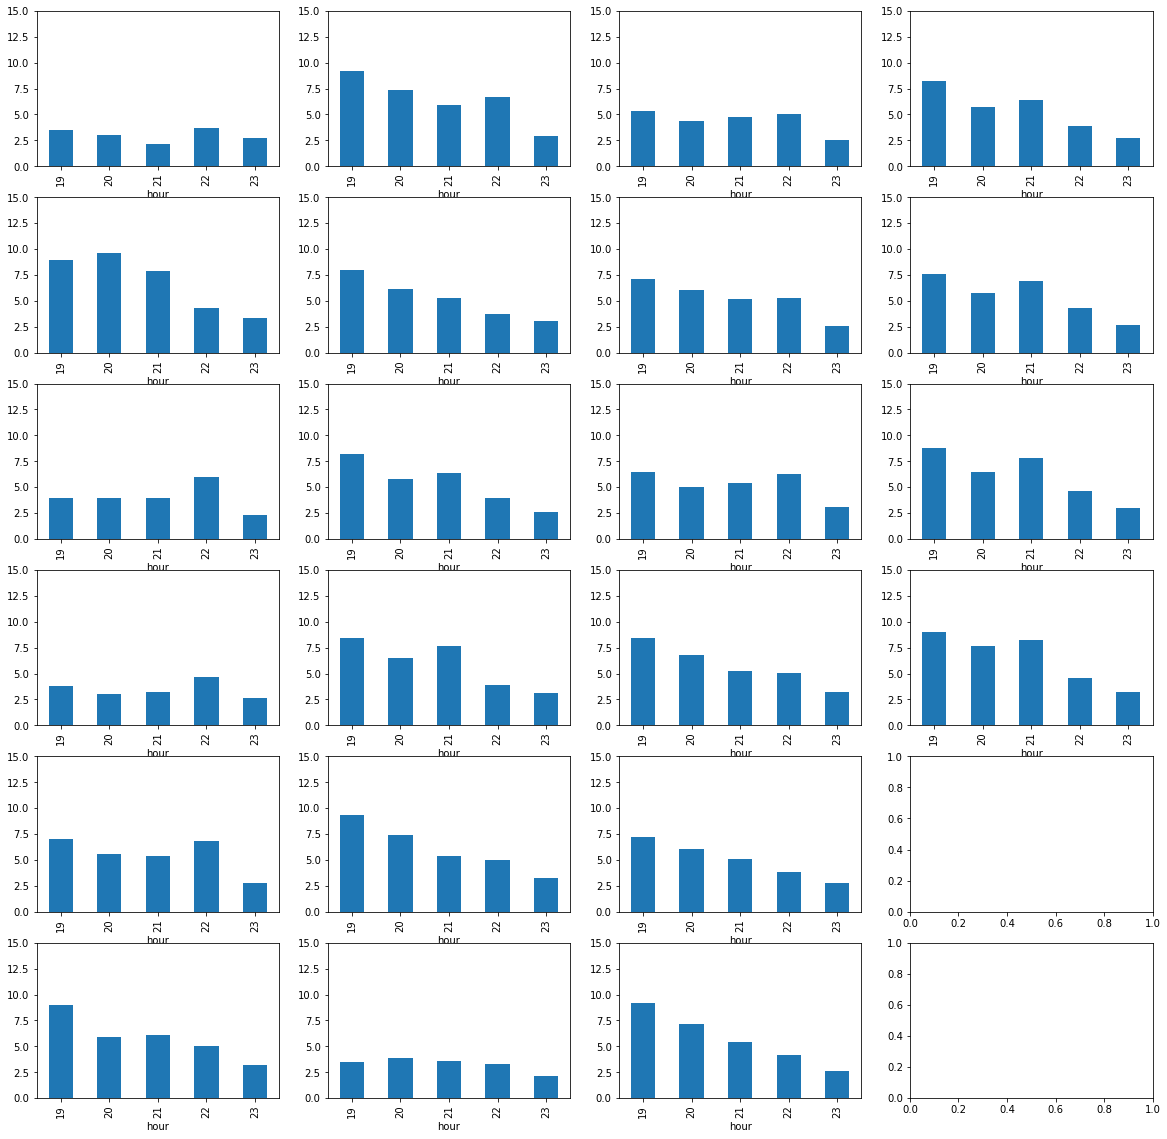

In [214]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 4, figsize=(20, 20))
r = 0
c = 0
i = 0

for stop_id in relevant_stops_N:
    subset = m7_N_time[m7_N_time.next_stop_id == stop_id]
    subset.groupby("hour").passenger_count.mean().plot.bar(ax=axs[r, c])
    axs[r, c].set_ylim([0, 15])
    i += 1
    r = i % 6
    c = i // 6


plt.show()
    

In [211]:
alert_subset = m7_N_time[m7_N_time.timestamp.dt.day == 28]
alert_subset.shape

(97, 26)

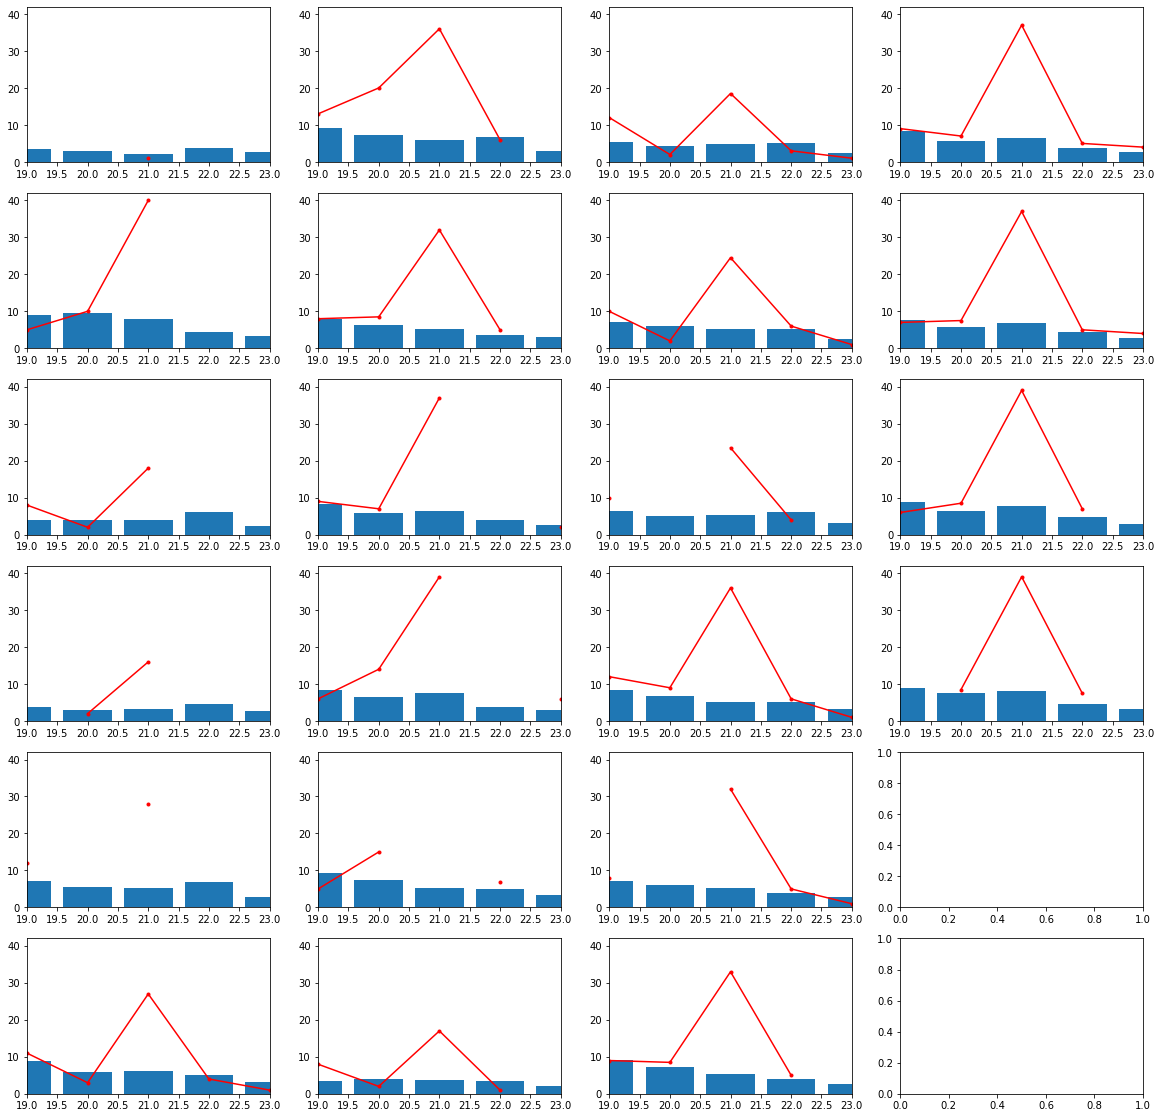

In [239]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 4, figsize=(20, 20))
r = 0
c = 0
i = 0

hours = [19, 20, 21, 22, 23]

for stop_id in relevant_stops_N:
    subset = m7_N_time[m7_N_time.next_stop_id == stop_id]
    axs[r,c].bar(hours, subset.groupby("hour").passenger_count.mean())
    #subset.groupby("hour").passenger_count.mean().plot.bar(ax=axs[r, c])
    alert_counts = []
    for hour in hours:
        count = alert_subset[(alert_subset.next_stop_id == stop_id) & (alert_subset.hour == hour)].passenger_count.mean()
        alert_counts.append(count)
        # try:
        # except:
        #     print("No count")
    axs[r, c].plot(hours, alert_counts, marker='o', markersize=3, color="red")
    axs[r, c].set_ylim([0, 42])
    axs[r, c].set_xlim([19, 23])
    i += 1
    r = i % 6
    c = i // 6


plt.show()
    

In [240]:
alert_subset.trip_id.unique()

array(['MTA NYCT_OF_D1-Weekday-SDon-143000_M1_139',
       'MTA NYCT_OF_D1-Weekday-SDon-147000_M1_141',
       'MTA NYCT_OF_D1-Weekday-SDon-121500_M7_234',
       'MTA NYCT_OF_D1-Weekday-SDon-129000_M7_239',
       'MTA NYCT_OF_D1-Weekday-SDon-131000_M1_141',
       'MTA NYCT_OF_D1-Weekday-SDon-137000_M1_142'], dtype=object)

Why is `M1` included in the trip ids?

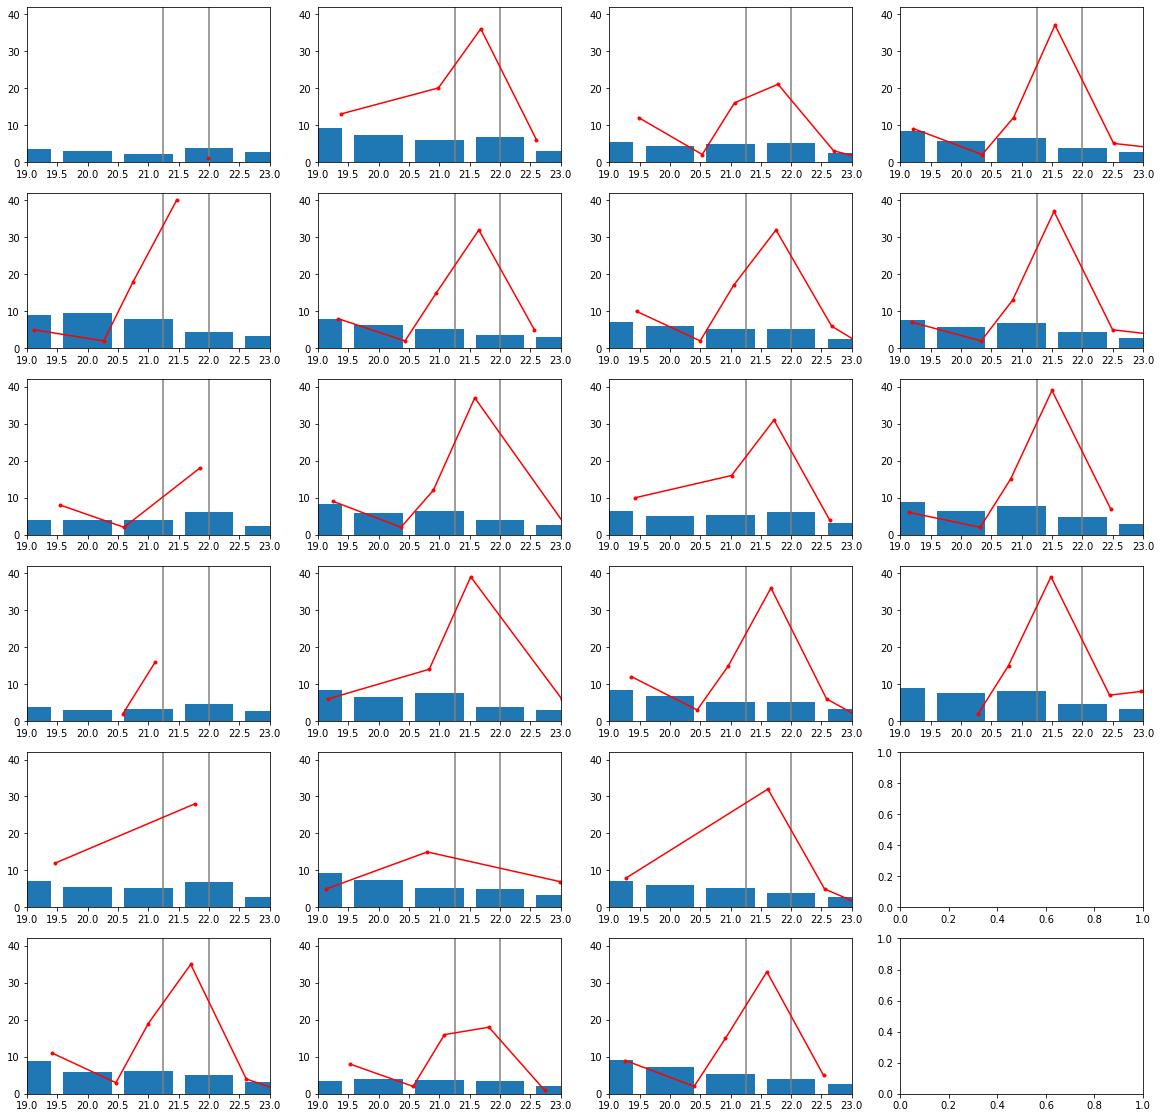

In [271]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 4, figsize=(20, 20))
r = 0
c = 0
i = 0

hours = [19, 20, 21, 22, 23]

for stop_id in relevant_stops_N:
    subset = m7_N_time[m7_N_time.next_stop_id == stop_id]
    axs[r,c].bar(hours, subset.groupby("hour").passenger_count.mean())
    #subset.groupby("hour").passenger_count.mean().plot.bar(ax=axs[r, c])
    alert_counts = []
    count = alert_subset[(alert_subset.next_stop_id == stop_id)]
    for j in range(count.shape[0]):
        alert_counts.append((
            count.passenger_count.values[j],
            (count.hour + count.timestamp.dt.minute / 60).values[j]
        ))
        # try:
        # except:
        #     print("No count")
    alert_counts = sorted(alert_counts, key = lambda x: x[1])
    times = [i[1] for i in alert_counts]
    counts = [i[0] for i in alert_counts]
    axs[r, c].axvline(x=21.25, c='gray')
    axs[r, c].axvline(x=22, c='gray')
    axs[r, c].plot(times, counts, marker='o', markersize=3, color="red")
    axs[r, c].set_ylim([0, 42])
    axs[r, c].set_xlim([19, 23])
    i += 1
    r = i % 6
    c = i // 6

plt.show()
    

### 2021-11-03
- Need to find relevant stops
- For entire day, for all stops, look at anomalous events
    - Might find events that aren't related to alerts
    - How much do (un)planned disruptions explain?
- Look into packages for graphs
    - Look at older work
    - Spatially --> look at proximity between subway stations and bus stops
- Manual: brute force or hand-pick specific area
- Look at outlying parts of network  (fewer alternatives, important from an equity point of view)  
    - Eric Goldwyn
- Missed runs    